In [44]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 420 (delta 12), reused 9 (delta 2), pack-reused 393 (from 1)
Receiving objects: 100% (420/420), 22.56 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/content/ELENA/ELENA/ELENA


In [45]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [114]:
# veff_elena.py – Abelian–Higgs effective potential with explicit T-dependence (3D DR form)
import numpy as np

# ---------- numerically safe helpers ----------
def _rtabs(x, floor=1e-30):
    """sqrt(|x|) with a tiny floor (keeps logs/ratios finite but preserves cancellations)."""
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x):
    return np.log(np.clip(np.abs(x), 1e-30, None))

# ---------- 4D input couplings ----------
g1_4   = 1.0
lam_4  = 0.005
m0sq_4 = -(130.0**2)
Yphi   = 1.0

# ---------- thermal matching (placeholder; swap with DRalgo) ----------
cT   = 0.30*(g1_4**2) + 0.10*lam_4
c_mu = 1.0

def match_3d_params(T):
    T = float(T)
    g1sq_3 = (g1_4**2) * T           # [mass]^1
    lam_3  = lam_4 * T               # [mass]^1
    msq_3  = m0sq_4 + cT * T*T       # [mass]^2
    mu3US  = c_mu * max(g1_4*T, 1.0) # keep >0 at very low T
    return g1sq_3, lam_3, msq_3, mu3US

# ---------- stable small-ϕ handling for the three blocks ----------
def _MG_abs(phi, g1sq):
    # exact |ϕ| dependence prevents spurious constant pieces in logs
    return np.abs(phi) * np.sqrt(np.maximum(g1sq * (Yphi**2), 1e-30))

def _N_block1(phi, g1sq, lam, msq, mu3US):
    pi2  = np.pi**2
    phi2 = phi*phi
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term1 =  (g1sq**2)*(Yphi**4)*phi2**2 / (8.0*pi2)
    term2 = -(g1sq*(Yphi**2)*phi2*(-msq + 2.0*g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)) / (16.0*pi2)
    term3 =  (g1sq*(Yphi**2)*phi2*MG*M3) / (8.0*pi2)
    term4 = - ((msq + 3.0*lam*phi2)**2) * (0.5 + _logsafe(mu3US / M3)) / (16.0*pi2)
    tmp   = (-msq + g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)
    term5 =  (tmp*tmp) * (0.5 + _logsafe(mu3US / (MG + M3))) / (8.0*pi2)
    term6n = ( 7.0*(g1sq**2)*(Yphi**4)*phi2**2 + tmp*tmp - 2.0*g1sq*(Yphi**2)*phi2*(msq + 3.0*lam*phi2) )
    term6  = - term6n * (0.5 + _logsafe(mu3US / (2.0*MG + M3))) / (16.0*pi2)
    return term1 + term2 + term3 + term4 + term5 + term6

def _N_block2(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2) * M1) / (16.0*pi2)
    t2 =  (M3 / (4.0*pi)) * ((g1sq*(Yphi**2)*phi2*M1)/(4.0*pi)
                             - (MG*(g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2))/(4.0*pi))
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _N_block3(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2) * M3) / (16.0*pi2)
    t2 =  (M1 / (4.0*pi)) * ( - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2)) /(4.0*pi)
                               + (g1sq*(Yphi**2)*phi2*M3) / (4.0*pi) )
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _block_stable(phi, g1sq, lam, msq, mu3US, Nfunc, phi_cut=1e-2, h_abs=1e-4):
    """
    Stable evaluation of N(phi)/(4 phi^2):
      if |phi|>=phi_cut -> direct ratio
      else -> even-limit via symmetric second-difference using a fixed |h| (not ∝phi)
    """
    phi = float(phi)
    if abs(phi) >= phi_cut:
        return Nfunc(phi, g1sq, lam, msq, mu3US) / (4.0 * phi*phi)
    h = h_abs
    Nhp = Nfunc(+h, g1sq, lam, msq, mu3US)
    Nhm = Nfunc(-h, g1sq, lam, msq, mu3US)
    a   = (Nhp + Nhm) / (2.0 * h*h)  # coefficient of phi^2 in N(phi)
    return 0.25 * a

# ---------- Effective potential ----------
def V(phi, T):
    phi = np.asarray(phi, dtype=float)
    T   = np.asarray(T,   dtype=float)

    g1sq, lam, msq, mu3US = match_3d_params(T)
    g1sq  = np.asarray(g1sq,  dtype=float)
    lam   = np.asarray(lam,   dtype=float)
    msq   = np.asarray(msq,   dtype=float)
    mu3US = np.asarray(mu3US, dtype=float)

    pi  = np.pi
    pi2 = pi**2

    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term_tree  = 0.5 * msq * phi2 + 0.25 * lam * phi2**2
    term_cg    = - (MG**3) / (6.0 * pi)
    term_c1    =  (g1sq * (Yphi**2) * MG * M1) / (16.0 * pi2)
    term_l1    =  (3.0 * lam * (msq + lam * phi2)) / (64.0 * pi2)
    term_sc1   = - (M1**3) / (12.0 * pi)
    term_c2    =  (g1sq * (Yphi**2) * MG * M3) / (16.0 * pi2)
    term_mix   =  (lam * M1 * M3) / (32.0 * pi2)
    term_l2    =  (3.0 * lam * (msq + 3.0 * lam * phi2)) / (64.0 * pi2)
    term_sc2   = - (M3**3) / (12.0 * pi)
    term_log_scalar = - (3.0 * lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (3.0 * M3)))
    term_last       = - (lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (2.0 * M1 + M3)))

    # stabilized blocks (vectorized over phi)
    b1 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block1)
    b2 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block2)
    b3 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block3)

    return term_tree + term_cg + term_c1 + term_l1 + term_sc1 + term_c2 + term_mix + term_l2 + term_sc2 + term_log_scalar + b1 + b2 + b3 + term_last

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    # step independent of phi near zero → stable with |ϕ| cusps
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)

if __name__ == "__main__":
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 1e-6, 1e-3, 0.1, 1.0, 10.0, 50.0]:
            print(f"T={T:6.1f}, phi={ph:9.6f}, V={V(ph,T): .4e}, dV={dV(ph,T): .4e}")


T=   0.0, phi= 0.000000, V=-1.1655e+05, dV= 0.0000e+00
T=   0.0, phi= 0.000001, V=-1.1655e+05, dV=-1.6900e-02
T=   0.0, phi= 0.001000, V=-1.1655e+05, dV=-1.6900e+01
T=   0.0, phi= 0.100000, V=-1.1664e+05, dV=-1.6900e+03
T=   0.0, phi= 1.000000, V=-1.2500e+05, dV=-1.6900e+04
T=   0.0, phi=10.000000, V=-9.6155e+05, dV=-1.6900e+05
T=   0.0, phi=50.000000, V=-2.1242e+07, dV=-8.4500e+05
T=  50.0, phi= 0.000000, V=-9.7381e+04, dV= 0.0000e+00
T=  50.0, phi= 0.000001, V=-9.7381e+04, dV= 5.4726e-01
T=  50.0, phi= 0.001000, V=-9.7381e+04, dV= 5.4726e+02
T=  50.0, phi= 0.100000, V=-9.7348e+04, dV=-4.8074e+02
T=  50.0, phi= 1.000000, V=-1.0435e+05, dV=-1.5084e+04
T=  50.0, phi=10.000000, V=-9.0933e+05, dV=-1.6503e+05
T=  50.0, phi=50.000000, V=-2.2007e+07, dV=-9.0723e+05
T= 100.0, phi= 0.000000, V=-8.0644e+04, dV= 0.0000e+00
T= 100.0, phi= 0.000001, V=-8.0644e+04, dV= 1.4643e+00
T= 100.0, phi= 0.001000, V=-8.0642e+04, dV= 1.4643e+03
T= 100.0, phi= 0.100000, V=-8.0417e+04, dV= 1.5603e+03
T= 100.0, 

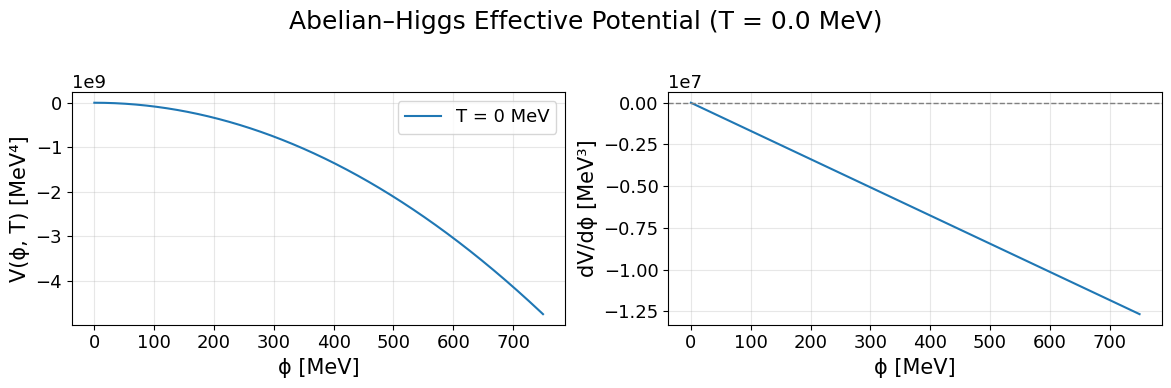

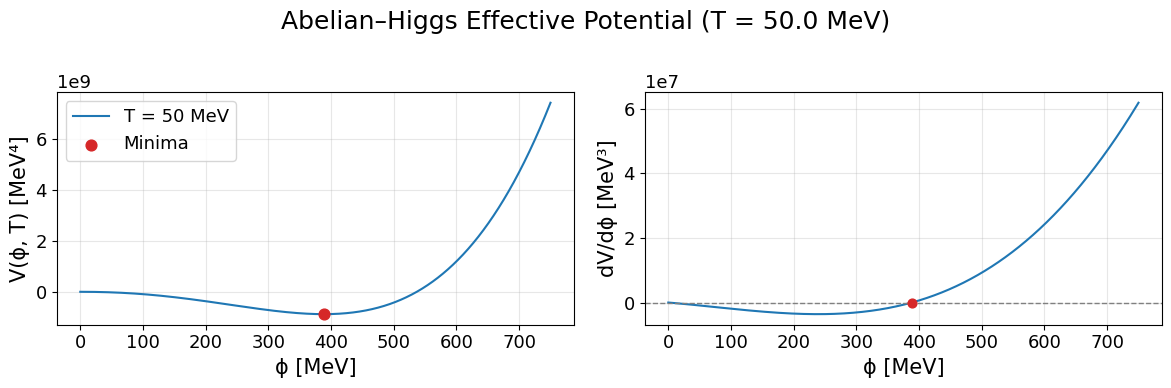

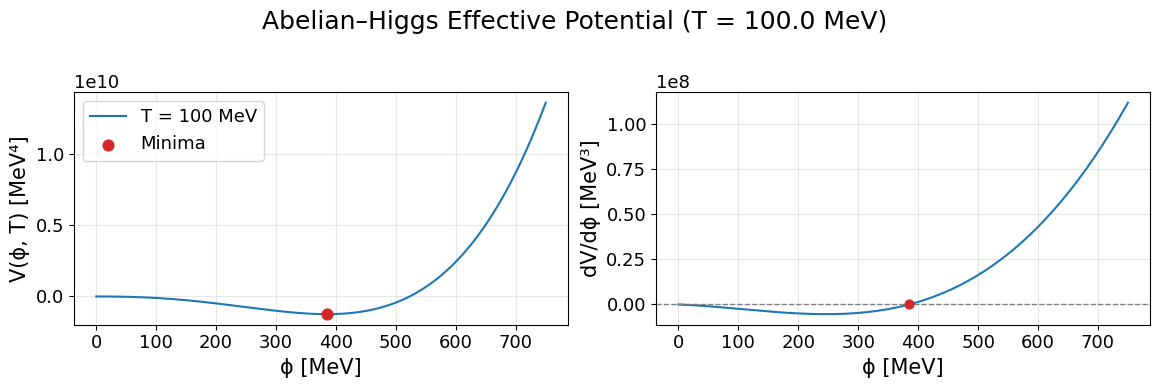

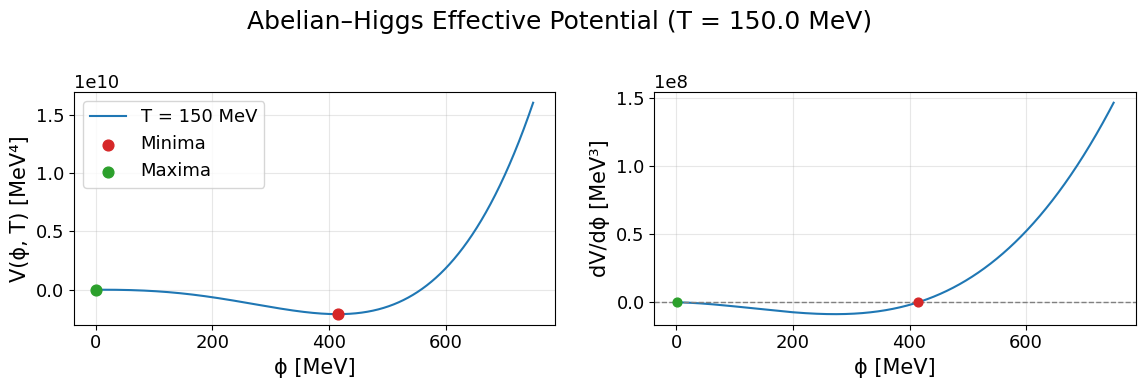

In [115]:
# plot_ah_potential.py – visualize Abelian–Higgs effective potential with explicit T-dependence
import numpy as np
import matplotlib.pyplot as plt
import warnings



# -------------------------------
# Global plot settings (no LaTeX)
# -------------------------------
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 18,
    'text.usetex': False
})

# -------------------------------
# Controls
# -------------------------------
vev   = 500.0                  # plot window scale [MeV]
units = "MeV"
temps = [0.0, 50.0, 100.0,150.0]  # scan a few T
phi   = np.linspace(0, 1.5*vev, 2601)

# -------------------------------
# Helpers to find extrema
# -------------------------------
def zero_crossings(x, y):
    """Return indices i where y crosses 0 between x[i] and x[i+1]."""
    s = np.sign(y)
    cross = np.where(s[:-1] * s[1:] < 0)[0]
    return cross

def interp_zero(x0, x1, y0, y1):
    """Linear interpolation for zero of y between (x0,y0) and (x1,y1)."""
    t = -y0 / (y1 - y0)
    return x0 + t*(x1 - x0)

def find_extrema(phi_grid, T, dV_vals=None):
    """
    Find stationary points solving dV=0 along the grid, classify them using a
    second-derivative sign test via finite differences.
    Returns list of (phi_star, kind) with kind in {'min','max','flat'}.
    """
    if dV_vals is None:
        dV_vals = dV(phi_grid, T)

    idxs = zero_crossings(phi_grid, dV_vals)
    extrema = []
    for i in idxs:
        # refine root by linear interpolation
        x0, x1 = phi_grid[i], phi_grid[i+1]
        y0, y1 = dV_vals[i], dV_vals[i+1]
        xc = interp_zero(x0, x1, y0, y1)

        # classify via finite-difference second derivative
        h  = max(1e-2, 1e-3*max(abs(xc), 1.0))
        fpp = (V(xc + h, T) - 2.0*V(xc, T) + V(xc - h, T)) / (h*h)

        if fpp > 0:
            kind = 'min'
        elif fpp < 0:
            kind = 'max'
        else:
            kind = 'flat'
        extrema.append((xc, kind))
    return extrema

# -------------------------------
# Plot
# -------------------------------
for T in temps:
    Vvals  = V(phi, T)
    dVvals = dV(phi, T)

    # find extrema
    extrema = find_extrema(phi, T, dVvals)
    mins = [x for x,k in extrema if k=='min']
    maxs = [x for x,k in extrema if k=='max']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Abelian–Higgs Effective Potential (T = {T:.1f} {units})", fontsize=18)

    # --- Left: V(φ) ---
    axes[0].plot(phi, Vvals, label=f"T = {T:.0f} {units}")
    # mark minima & maxima
    if mins:
        axes[0].scatter(mins, [V(m, T) for m in mins], s=60, c='tab:red', label='Minima', zorder=5)
    if maxs:
        axes[0].scatter(maxs, [V(m, T) for m in maxs], s=60, c='tab:green', label='Maxima', zorder=5)
    axes[0].set_xlabel(f"ϕ [{units}]")
    axes[0].set_ylabel(f"V(ϕ, T) [{units}⁴]")
    axes[0].grid(alpha=0.3)
    axes[0].legend(loc="best")

    # annotate two-well structure on φ≥0 side if present
    mins_pos = sorted([m for m in mins if m >= 0.0])
    if len(mins_pos) >= 1:
        m0 = mins_pos[0]
        V0 = V(m0, T)
        # find next minimum to the right if any
        if len(mins_pos) >= 2:
            m1 = mins_pos[1]
            V1 = V(m1, T)
            axes[0].annotate("Barrier", xy=(0.5*(m0+m1), V(0.5*(m0+m1), T)),
                             xytext=(0.5*(m0+m1), V(0.5*(m0+m1), T) + 0.1*abs(V1 - V0) + 1e-3),
                             arrowprops=dict(arrowstyle="->", lw=1))

    # --- Right: dV/dφ ---
    axes[1].plot(phi, dVvals)
    axes[1].axhline(0, color="gray", linestyle="--", linewidth=1)
    if mins:
        axes[1].scatter(mins, [0.0]*len(mins), s=40, c='tab:red', zorder=5)
    if maxs:
        axes[1].scatter(maxs, [0.0]*len(maxs), s=40, c='tab:green', zorder=5)
    axes[1].set_xlabel(f"ϕ [{units}]")
    axes[1].set_ylabel(f"dV/dϕ [{units}³]")
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

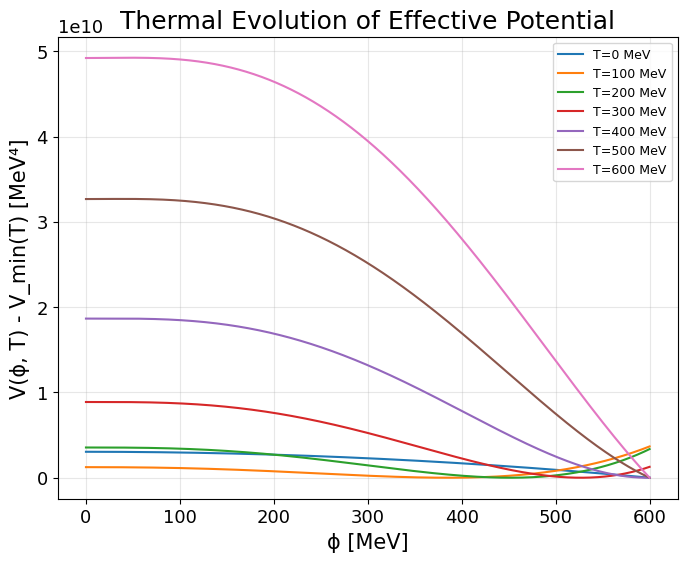

In [116]:
import numpy as np
import matplotlib.pyplot as plt


Tscan = np.linspace(0, 600, 25)   # MeV
phi   = np.linspace(0, 600, 2001)

plt.figure(figsize=(8,6))
for T in Tscan[::4]:  # plot a few representative temperatures
    Vvals = V(phi, T)
    Vvals -= Vvals.min()           # normalize so min=0 for visibility
    plt.plot(phi, Vvals, label=f"T={T:.0f} MeV")

plt.xlabel("ϕ [MeV]")
plt.ylabel("V(ϕ, T) - V_min(T) [MeV⁴]")
plt.title("Thermal Evolution of Effective Potential")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.show()
